In [839]:
#import dependencies
import json
import requests
from pprint import pprint
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt
import scipy.stats as stats

 # Import the required libraries
import hvplot.pandas
import holoviews as hv

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [840]:
#Pull csv file as dataframe and view top 5 rows
yelp_toronto = '../Data/tor_data.csv'
yelp_vancouver = '../Data/van_data.csv'

toronto_data = pd.read_csv(yelp_toronto, encoding='utf-8')
vancouver_data = pd.read_csv(yelp_vancouver, encoding='utf-8')

toronto_df = pd.DataFrame(toronto_data)
vancouver_df = pd.DataFrame(vancouver_data)

toronto_df.head()

,Restaurant Name,Address,Category,Rating,Number of Reviews,Price($),Price(1-5),Latitude,Longitude
0,Pai Northern Thai Kitchen,18 Duncan Street,Thai,4.5,3335,$$,2,43.647840,-79.388720
1,Richmond Station,1 Richmond Street W,Canadian (New),4.5,869,$$$,3,43.651373,-79.379285
2,Mira,420A Wellington Street W,Peruvian,4.5,256,$$,2,43.644170,-79.396390
3,Rasa,196 Robert Street,Canadian (New),4.5,317,$$,2,43.662775,-79.403968
4,KINKA IZAKAYA ORIGINAL,398 Church Street,Japanese,4.0,1790,$$,2,43.660424,-79.378900


In [841]:
#Find Yelp Categories unique to each city and cleanup the data based on number of reviews
#Remove any ambiguous categories from results
torcats = pd.Index(toronto_data['Category'].unique())
vancats = pd.Index(vancouver_data['Category'].unique())

torcat_unique = pd.Series(torcats.difference(vancats))
vancat_unique = pd.Series(vancats.difference(torcats))

torcats_df = toronto_data.loc[(toronto_data['Category'].isin(torcat_unique)) & (toronto_data['Number of Reviews'] > 100) & (toronto_data['Category'] != 'Food Court') & (toronto_data['Category'] != 'Arcades'), :]
vancats_df = vancouver_data.loc[(vancouver_data['Category'].isin(vancat_unique)) & (vancouver_data['Number of Reviews'] > 100) & (vancouver_data['Category'] != 'Organic Stores') & (vancouver_data['Category'] != 'Dive Bars') & (vancouver_data['Category'] != 'Irish') & (vancouver_data['Category'] != 'Patisserie/Cake Shop'), :]


In [842]:
#Map unique restaurants in Toronto
unique_tor_plot = torcats_df.hvplot.points('Longitude', 'Latitude', geo=True, tiles='StamenTonerBackground', frame_width = 1000, frame_height = 800, size='Number of Reviews', color='Category', legend=None)

unique_tor_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Category,Number of Reviews)

In [843]:
#Map unique restaurants in Vancouver
unique_van_plot = vancats_df.hvplot.points('Longitude', 'Latitude', geo=True, tiles='StamenTonerBackground', frame_width = 800, frame_height = 600, size='Number of Reviews', color='Category')

unique_van_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Category,Number of Reviews)

In [844]:
#Generate a lit of categories for restaurants that have more than 1000 total reviews and more than 10 restaurants
torcat_rest = pd.DataFrame(toronto_df.groupby('Category').count()['Restaurant Name'])
torcat_rev = pd.DataFrame(toronto_df.groupby('Category').sum()['Number of Reviews'])

vancat_rest = pd.DataFrame(vancouver_df.groupby('Category').count()['Restaurant Name'])
vancat_rev = pd.DataFrame(vancouver_df.groupby('Category').sum()['Number of Reviews'])


vancategory_df = vancat_rest.join(vancat_rev)
torcategory_df = torcat_rest.join(torcat_rev)

van_category_df_red = pd.Series((vancategory_df.loc[(vancategory_df['Number of Reviews'] > 1000) & (vancategory_df['Restaurant Name'] > 10), :]).index)
tor_category_df_red = pd.Series((torcategory_df.loc[(torcategory_df['Number of Reviews'] > 1000) & (torcategory_df['Restaurant Name'] > 10), :]).index)

In [845]:
#Create a data frame of restaurants in Toronto with more than 10 reviews and matches the reduced category list from above
tor_df_1 = toronto_df.loc[(toronto_df['Category'].isin(tor_category_df_red)) & (toronto_df['Number of Reviews'] > 10), :]

#Add a column for the total Number of reviews for each category and sum the reviews for that particular category
tordict = tor_df_1.groupby('Category').sum()['Number of Reviews']
tor_df_1['Total Cat Ratings'] = tor_df_1['Category'].map(tordict)

#Create an empty column for the Weighted Rating for that restaurant proportional to the number of reviews for that category
tor_df_1['Weighted Rating'] = ''

tor_df_1

,Restaurant Name,Address,Category,Rating,Number of Reviews,Price($),Price(1-5),Latitude,Longitude,Total Cat Ratings,Weighted Rating
0,Pai Northern Thai Kitchen,18 Duncan Street,Thai,4.5,3335,$$,2,43.647840,-79.388720,6985,
1,Richmond Station,1 Richmond Street W,Canadian (New),4.5,869,$$$,3,43.651373,-79.379285,5274,
3,Rasa,196 Robert Street,Canadian (New),4.5,317,$$,2,43.662775,-79.403968,5274,
4,KINKA IZAKAYA ORIGINAL,398 Church Street,Japanese,4.0,1790,$$,2,43.660424,-79.378900,10625,
5,Katsuya,66 Gerrard Street E,Japanese,4.5,478,$$,2,43.659950,-79.378820,10625,
...,...,...,...,...,...,...,...,...,...,...,...
990,Nobuya,285 Royal York Road,Japanese,4.0,201,$$,2,43.614510,-79.497410,10625,
993,Mr Jerk,209 Wellesley Street E,Caribbean,4.0,88,$,1,43.667210,-79.373200,2096,
995,KoSam,5865 Leslie Street,Korean,4.0,196,$$,2,43.798412,-79.368898,3268,
997,Casa Di Giorgios,1646 Queen St E,Italian,4.0,74,$$,2,43.666850,-79.315180,9964,


In [846]:
#Create a data frame of restaurants in Vancouver with more than 10 reviews and matches the reduced category list from above
van_df_1 = vancouver_df.loc[(vancouver_df['Category'].isin(van_category_df_red)) & (vancouver_df['Number of Reviews'] > 10), :]

#Add a column for the total Number of reviews for each category and sum the reviews for that particular category
vandict = van_df_1.groupby('Category').sum()['Number of Reviews']
van_df_1['Total Cat Ratings'] = van_df_1['Category'].map(vandict)

#Create an empty column for the Weighted Rating for that restaurant proportional to the number of reviews for that category
van_df_1['Weighted Rating'] = ''

van_df_1

,Restaurant Name,Address,Category,Rating,Number of Reviews,Price($),Price(1-5),Latitude,Longitude,Total Cat Ratings,Weighted Rating
0,The Flying Pig,1168 Hamilton Street,Canadian (New),4.0,1247,$$,2,49.275010,-123.122000,8056,
1,Kosoo,1128 Robson Street,Korean,4.5,69,$$,2,49.284940,-123.125920,2550,
3,Miku,200 Granville Street,Japanese,4.5,2107,$$$,3,49.286918,-123.112763,15440,
4,Kingyo,871 Denman Street,Japanese,4.5,1012,$$,2,49.290610,-123.137140,15440,
5,Dinesty Dumpling House,1719 Robson Street,Chinese,4.0,900,$$,2,49.290818,-123.134391,6680,
...,...,...,...,...,...,...,...,...,...,...,...
990,La Buca Restaurant,4025 MacDonald Street,Italian,4.0,61,$$$,3,49.250648,-123.168016,6656,
995,Pink Peppercorn Seafood House,1485 Kingsway,Seafood,4.0,139,$$$,3,49.249358,-123.073916,10506,
997,The Viet Noodle Guy,1902 Rosser Avenue,Vietnamese,4.0,168,$$,2,49.267220,-123.005728,3954,
998,Corner 23,4008 Cambie Street,Chinese,3.0,128,$$,2,49.249950,-123.114950,6680,


In [847]:
#Define a function that calculates the weighted rating of each restaurant by multiplying the rating by the number of reviews for that restaurant proportional to the total number of reviews for the category
def weighted_rating(rating, reviews, totals):
    return (rating*reviews)/totals

#Iterate through the rows of the Toronto dataframe to caculate the weighted rating of each restaurant
for row in tor_df_1.iterrows():
    rating = tor_df_1['Rating']
    reviews = tor_df_1['Number of Reviews']
    totals = tor_df_1['Total Cat Ratings']
    tor_df_1['Weighted Rating'] = weighted_rating (rating, reviews, totals)

#Iterate through the rows of the Vancouver dataframe to caculate the weighted rating of each restaurant
for row in van_df_1.iterrows():
    rating = van_df_1['Rating']
    reviews = van_df_1['Number of Reviews']
    totals = van_df_1['Total Cat Ratings']
    van_df_1['Weighted Rating'] = weighted_rating (rating, reviews, totals)

#Create a data frame for the weighted rating and total number of restaurants for each category for both cities
van_cat_plotdata_1 = pd.DataFrame(van_df_1.groupby(van_df_1['Category']).sum()['Weighted Rating'])
van_cat_plotdata_2 = pd.DataFrame(van_df_1.groupby(van_df_1['Category']).count()['Restaurant Name'])

tor_cat_plotdata_1 = pd.DataFrame(tor_df_1.groupby(tor_df_1['Category']).sum()['Weighted Rating'])
tor_cat_plotdata_2 = pd.DataFrame(tor_df_1.groupby(tor_df_1['Category']).count()['Restaurant Name'])

plotdata_wr = tor_cat_plotdata_1.merge(van_cat_plotdata_1, on='Category').rename(columns={'Weighted Rating_x':'Toronto Weighted Rating', 'Weighted Rating_y':'Vancouver Weighted Rating'})
plotdata_rn = tor_cat_plotdata_2.merge(van_cat_plotdata_2, on='Category').rename(columns={'Restaurant Name_x':'Toronto Restaurant Total', 'Restaurant Name_y':'Vancouver Restaurant Total'})

plotdata_wr


,Toronto Weighted Rating,Vancouver Weighted Rating
Category,,
Breakfast & Brunch,4.020912,4.132371
Cafes,4.140502,4.224266
Canadian (New),4.079731,4.004469
Chinese,3.975345,3.826796
Coffee & Tea,4.242308,3.892346
French,3.956237,4.105346
Italian,3.879868,3.979192
Japanese,4.035718,4.163245
Korean,3.969706,3.950196


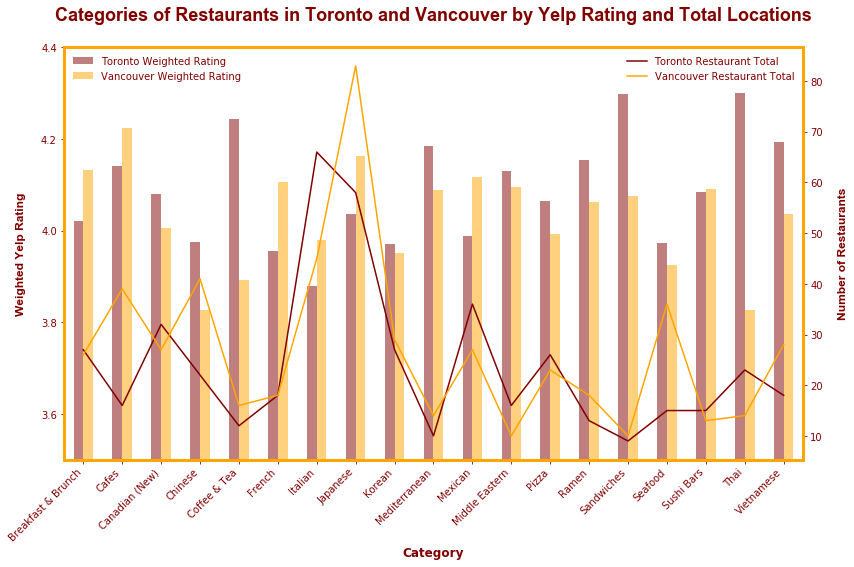

In [848]:
# Create the figure and axes object
fig, ax1 = plt.subplots()
# Plot the first x and y axes:
plotdata_wr.plot(
    use_index=True, 
    kind='bar',
    y=['Toronto Weighted Rating', 'Vancouver Weighted Rating'], 
    ax=ax1,
    figsize=(12,8),
    ylim=(3.5,4.4),
    alpha=0.5,
    color=['maroon', 'orange']
)

#Set labels for original plot with legends and colors configured
ax1.set_ylabel('Weighted Yelp Rating', fontsize=12, labelpad=15, fontname='Arial', fontweight='bold', color='maroon')
ax1.set_xticklabels(plotdata_rn.index, rotation=45, ha='right', color='maroon')
ax1.set_xlabel('Category' ,fontsize=12, fontweight='bold', color='maroon')

leg1 = ax1.legend(loc='upper left', frameon=False)
for text in leg1.get_texts():
    text.set_color("maroon")

#Configure second plot to share x axis with original plot
ax2 = ax1.twinx()

# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
plotdata_rn.plot(
    use_index=True, 
    y=['Toronto Restaurant Total', 'Vancouver Restaurant Total'], 
    ax=ax2, 
    color=['maroon', 'orange']
)
ax2.set_ylabel('Number of Restaurants', fontsize=12, fontname='Arial', labelpad=15, fontweight='bold', color='maroon')

# Configure legend color, frame and position
leg2 = ax2.legend(loc='upper right', frameon=False)
for text in leg2.get_texts():
    text.set_color("maroon")

#Change frame color of entire plot while maintaining ticklines
ax2.spines['bottom'].set_color('orange')
ax2.spines['bottom'].set_linewidth(3)
ax2.spines['top'].set_color('orange') 
ax2.spines['top'].set_linewidth(3)
ax2.spines['right'].set_color('orange')
ax2.spines['right'].set_linewidth(3)
ax2.spines['left'].set_color('orange')
ax2.spines['left'].set_linewidth(3)
ax1.tick_params(colors='maroon', which='both')
ax2.tick_params(colors='maroon', which='both')


# Configure title characteristics
ax1.set_title('Categories of Restaurants in Toronto and Vancouver by Yelp Rating and Total Locations', fontsize=18, fontweight='bold', fontname='Arial', y=1.05, color='maroon')

plt.show()

In [849]:
# CHI SQUARE TESTS
print('CHI SQUARE TESTS')
print('********************************************')

# Are the Yelp ratings of the categories of restaurants independently distributed?
#Define variables in the Chi square test and add Null/Alternative Hypotheses
chi_wrstat, chi_wrp, chi_wrdof, chi_wrexpected = stats.chi2_contingency(plotdata_wr)
chi_wrprob = 0.95
chi_wrcritical = stats.chi2.ppf(chi_wrprob, chi_wrdof)
H0 = 'The distribution of Yelp Ratings by category is independent between Toronto and Vanouver.'
HA = 'The distribution of Yelp Ratings by category is not independent between Toronto and Vancouver.'

print('Are the Yelp ratings of the categories of restaurants independently distributed?')
print('')
print('probability=%.3f, critical value=%.3f, stat=%.3f' % (chi_wrprob, chi_wrcritical, chi_wrstat))

if abs(chi_wrstat) >= chi_wrcritical:
    print(HA)
else:
    print(H0)
# interpret p-value
chi_wralpha = 1.0 - chi_wrprob
print('significance=%.3f, p=%.3f' % (chi_wralpha, chi_wrp))
if chi_wrp <= chi_wralpha:
    print(HA)
else:
    print(H0)

print('')
print('*********************************************')

# Is the distribution of restaurants by Yelp category independent between Toronto and Vancouver independant? 
#Define variables in the Chi square test and add Null/Alternative Hypotheses
chi_wrstat, chi_wrp, chi_wrdof, chi_wrexpected = stats.chi2_contingency(plotdata_rn)
chi_wrprob = 0.95
chi_wrcritical = stats.chi2.ppf(chi_wrprob, chi_wrdof)
H01 = 'The distribution of Restaurants by Yelp category is independent between Toronto and Vanouver.'
HA1 = 'The distribution of Restaurants by Yelp category is not independent between Toronto and Vancouver.'

print('Is the distribution of restaurants across categories independent between Toronto and Vancouver?')
print('')
print('probability=%.3f, critical value=%.3f, stat=%.3f' % (chi_wrprob, chi_wrcritical, chi_wrstat))
if abs(chi_wrstat) >= chi_wrcritical:
    print(HA1)
else:
    print(H01)
# interpret p-value
chi_wralpha = 1.0 - chi_wrprob
print('significance=%.3f, p=%.3f' % (chi_wralpha, chi_wrp))
if chi_wrp <= chi_wralpha:
    print(HA1)
else:
    print(H01)

CHI SQUARE TESTS
********************************************
Are the Yelp ratings of the categories of restaurants independently distributed?

probability=0.950, critical value=28.869, stat=0.061
The distribution of Yelp Ratings by category is independent between Toronto and Vanouver.
significance=0.050, p=1.000
The distribution of Yelp Ratings by category is independent between Toronto and Vanouver.

*********************************************
Is the distribution of restaurants across categories independent between Toronto and Vancouver?

probability=0.950, critical value=28.869, stat=39.063
The distribution of Restaurants by Yelp category is not independent between Toronto and Vancouver.
significance=0.050, p=0.003
The distribution of Restaurants by Yelp category is not independent between Toronto and Vancouver.


In [850]:
#Create a list of categories to use for independent t-test
category_list = ['Breakfast & Brunch', 'Cafes', 'Canadian (New)', 'Chinese', 'Coffee & Tea', 'French', 'Italian', 'Japanese', 'Korean', 'Mediterranean', 'Middle Eastern', 'Ramen', 'Sandwiches', 'Seafood', 'Sushi Bars', 'Thai', 'Mexican', 'Pizza', 'Vietnamese']
t_test_results = []

# Run an independent t-test for the categories in the category list and add them to a separate datafram
for category in category_list:
    tor_ttest_cat = tor_df_1.loc[tor_df_1['Category'] == category, :]
    van_ttest_cat = van_df_1.loc[van_df_1['Category'] == category, :]

    t_test_results.append(stats.ttest_ind(tor_ttest_cat['Weighted Rating'], van_ttest_cat['Weighted Rating'], equal_var=False))

t_test_results_df = pd.DataFrame(category_list).join(pd.DataFrame(t_test_results))


t_test_results_df

,0,statistic,pvalue
0,Breakfast & Brunch,-0.163857,0.870648
1,Cafes,1.934556,0.069992
2,Canadian (New),-0.500657,0.618556
3,Chinese,1.754715,0.090114
4,Coffee & Tea,1.180503,0.249528
5,French,-0.116881,0.907673
6,Italian,-1.844154,0.069229
7,Japanese,1.196994,0.233897
8,Korean,0.267902,0.789803
9,Mediterranean,0.479953,0.640299
